## Andrii Zadaianchuk, NIP 
### Desicion Tree with Information Gain spliting creteria

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import scipy.stats
import math
from __future__ import division
from IPython.core.debugger import Tracer; 

In [2]:
import numpy as np
from __future__ import division

# simulate two data sets. W is the same.
nn=50
nt=500
W=np.random.randn(1,nn)
X_train=np.sign(np.random.randn(nn,nt))
y_train=np.squeeze((1+np.sign(np.dot(W,X_train)))/2) 

X_test=np.sign(np.random.randn(nn,nt))
y_test=np.squeeze((1+np.sign(np.dot(W,X_test)))/2)


In [3]:
class Node(object):
    def __init__(self, data):
        self.data = data
        self.children = []

    def add_child(self, obj):
        self.children.append(obj)
    @property 
    def is_leaf(self):
        return not self.children

In [4]:
def entropy(y):
    p_1=np.sum(y)/y.shape[0] #probability of y=1
    p_y=[p_1, 1-p_1]
    return scipy.stats.entropy(p_y,base=2)

def crossentropy(y,y_test):
    p_1=np.sum(y)/y.shape[0] 
    p_y=[p_1, 1-p_1]
    p_1_test=np.sum(y_test)/y_test.shape[0]
    p_y_test=[p_1_test, 1-p_1_test]
    if (scipy.stats.entropy(p_y)==0)and(p_y_test==p_y):
        return 0;
    return -np.sum(p_y_test*np.log2(p_y))

def s_rel_entropy(y,atr,attribute):
    y_cond=y[attribute==atr]
    p_1_cond=np.sum(y_cond)/y_cond.shape[0]
    p_y_cond=[p_1_cond,1-p_1_cond]
    return scipy.stats.entropy(p_y_cond,base=2)

s_rel_entropy_vec=np.vectorize(s_rel_entropy,excluded=[0,2]) # to find rel entropies for all 
                                                             # different values of attribute (+1 -1 )

def find_information_gain(Node):
    try:
        return Node.information_gain_max #to not count the gain twice 
    except AttributeError:
        pass
    X=Node.data[0]
    y=Node.data[1]
    h_y=entropy(y)
    information_gain=[]
    
    #look for all atrributes to find best information gain
    for i in range(X.shape[0]):
        attribute=X[i,:]
        unique_attr=np.unique(attribute) #in our case will be -1 +1 
        p_a=np.array([np.sum(attribute==atr)/attribute.shape[0] for atr in list(unique_attr)]) #distribution of i attribute
        
        specific_relative_entropy=s_rel_entropy_vec(y,unique_attr,attribute)
        relative_entropy=np.sum(p_a*specific_relative_entropy)
        information_gain.append(h_y-relative_entropy)       
    
    Node.information_gain_max=np.max(information_gain)
    Node.ind_of_best_attribute=np.argmax(information_gain)
    return np.max(information_gain)

def find_leafs(Node):
    leafs=[]
    if Node.is_leaf:
        leafs.append(Node)
    else:
        for Node in Node.chindren:           
            leafs.extend(find_leafs(Node))
    return leafs

            

In [5]:
#initialization
Tree=Node((X_train,y_train))
Tree.path=[]
leafs=[Tree]
max_information_gain=1 # simply something >0

# lists with iteration information to plot
entropy_vec=[]
cross_entropy_vec=[]
weights=[]

while max_information_gain>0:
    information_gain=[find_information_gain(leaf)*(leaf.data[1].shape[0]/nt) for leaf in leafs] # the values of max Gains of all leafs
    max_information_gain=np.max(information_gain)
    split_node=leafs[np.argmax(information_gain)] # the node with best max Gains
    
    X=split_node.data[0]
    y=split_node.data[1]
    split_node.attribute=split_node.ind_of_best_attribute 
    attribute=X[split_node.ind_of_best_attribute,:]
    unique_attr=np.unique(attribute)  #in our case will be -1 +1 
    
    #look at W_kj
    weights.append(W[0,split_node.attribute])
    
    # adding new nodes to "best max Gain" node, the amount is equal to 
    for atr in list(unique_attr):
        ind=attribute==atr 
        new_node=Node((X[:,ind],y[ind])) #create new node with (X_atr,y) where X is splited to parts 
        new_node.path=split_node.path+[(split_node.attribute,atr)] #add information (j, +-1) to node
        split_node.add_child(new_node)
    split_node.data=[]     
    leafs.remove(split_node)
    leafs.extend(split_node.children)
    
    
    # find conditional entropy and cross entropy 
    ent=0
    cross_ent=0
    for leaf in leafs:
        y=leaf.data[1]    
        x_leaf=np.expand_dims(np.array(zip(*leaf.path)[1]),1) #the values of x that is determind in this leaf [-1, 1, 1, 1]
#         print len(x_leaf)
        ind=np.all(X_test[zip(*leaf.path)[0],:]==x_leaf,0) #the ind of X_test that have to be in this leaf
        y_test_leaf=y_test[ind]        
        X_test_leaf=X_test[:,ind]
        
        h_y=entropy(y)
        h_cross=crossentropy(y,y_test_leaf)
        p_x=leaf.data[0].shape[1]/nt
        p_x_test=X_test_leaf.shape[1]/nt
    
        ent+=h_y*p_x 
        cross_ent+=h_cross*p_x_test
        
    entropy_vec.append(ent)
    cross_entropy_vec.append(cross_ent)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: divide by zero encountered in log2
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars


We can see that cross entropy quickly became $+\infty$ because, we get leaf where all objects have the same class $P(Y_{train}=1|L_k)=0$ and therefore $H(Y|L_{k})=0$, where as test object have different $P(Y_{test}=1|L_k)\neq0$ and $P(Y_{test}=0|L_k)\neq0$

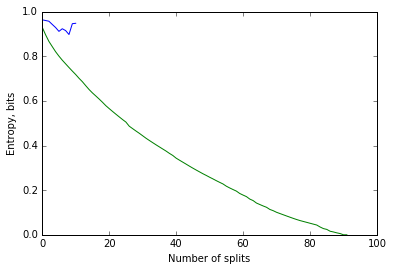

In [28]:
en=plt.plot(cross_entropy_vec,label='entropy')
cren=plt.plot(entropy_vec,label='crossentropy')
plt.ylabel('Entropy, bits')
plt.xlabel('Number of splits')
plt.savefig('entropy.pdf', format='pdf')

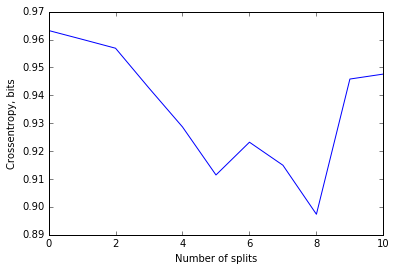

In [29]:
plt.plot(cross_entropy_vec)

plt.ylabel('Crossentropy, bits')
plt.xlabel('Number of splits')
plt.savefig('crossentropy.pdf', format='pdf')

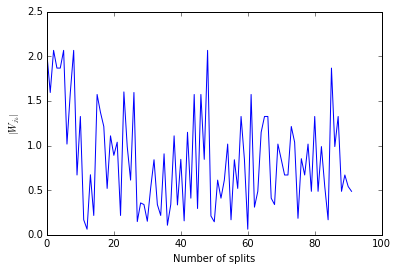

In [30]:
plt.plot(np.abs(weights))
plt.ylabel('$|W_{j_{k}} |$')
plt.xlabel('Number of splits')
plt.savefig('weights.pdf', format='pdf')

We can see and in avarage our weights are first bigger and than decreasing

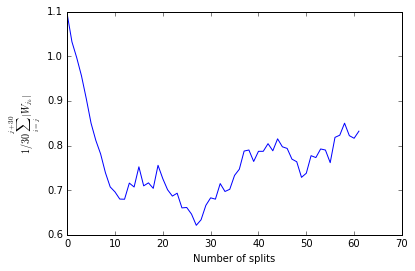

In [31]:
N_sp=len(weights)
weights_av=[np.sum(np.abs(weights)[i:i+30])/30 for i in range(N_sp-30)] 
plt.plot(weights_av)
plt.ylabel('$1/30\sum_{i=j}^{j+30}|W_{j_{k}} |$')
plt.xlabel('Number of splits')
plt.savefig('avarage_weights.pdf', format='pdf')